In [14]:
# ## 1. Imports and Data Loading
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


In [13]:
# Install necessary time-series libraries (statsmodels for SARIMA)
!pip install --quiet statsmodels



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# Load the CSV you provided
df = pd.read_csv('monthly_sales.csv')

In [16]:
# Rename and parse dates
df.rename(columns={'sale_month':'Date','total_sales':'Sales'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'] + '-01')      # convert 'YYYY-MM' to a true date
df.set_index('Date', inplace=True)

In [17]:
# Aggregate to ensure monthly frequency
monthly_sales = df['Sales'].resample('ME').sum()

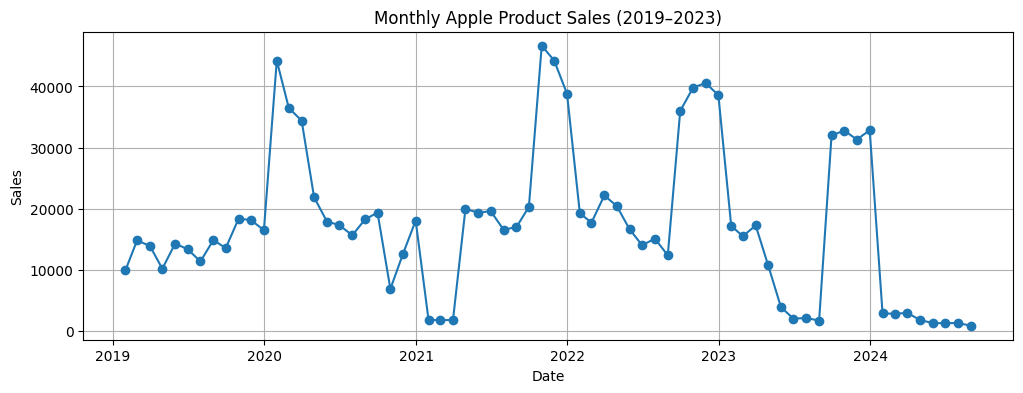

In [19]:
# ## 2. Exploratory Data Analysis
plt.figure(figsize=(12,4))
plt.plot(monthly_sales, marker='o')
plt.title('Monthly Apple Product Sales (2019–2023)')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()

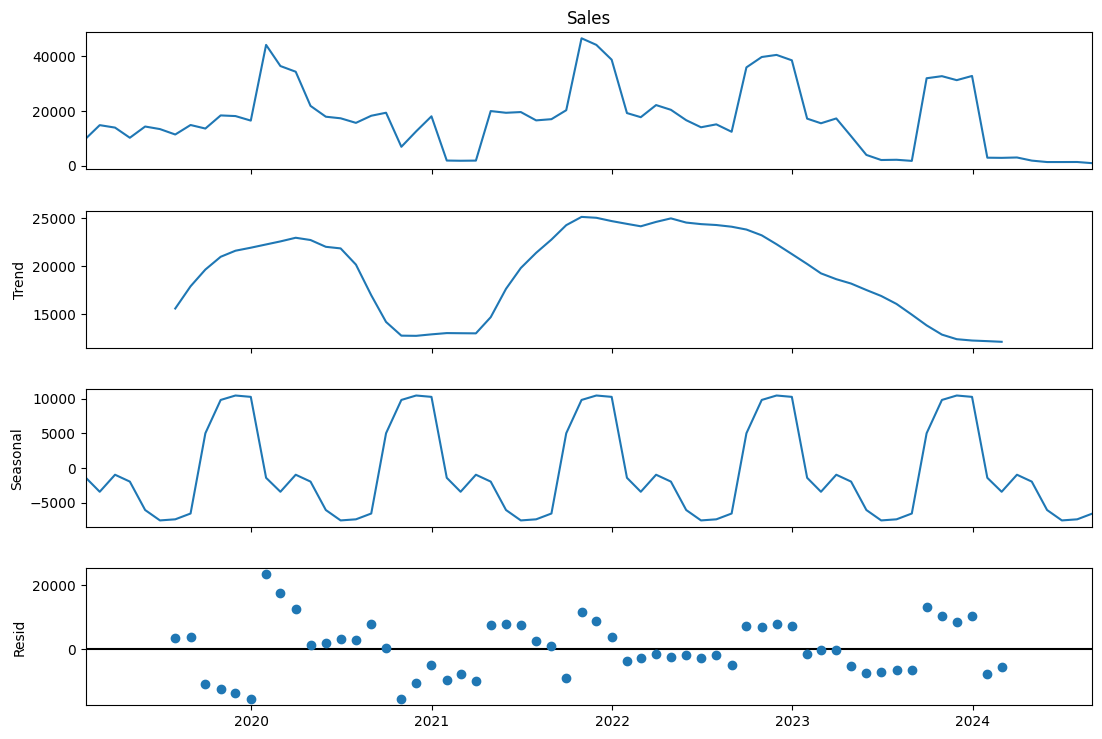

In [20]:
# Decompose into trend / seasonality / residuals
decomp = seasonal_decompose(monthly_sales, model='additive')
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.show()

In [21]:
# ## 3. Train–Test Split
# Hold out the last 12 months for testing
train = monthly_sales[:-12]
test  = monthly_sales[-12:]

In [22]:
# ## 4. Manual Grid-Search for Best SARIMA by AIC
# We'll search p, d, q and seasonal P, D, Q in {0,1} with m=12
import itertools

In [23]:
p = d = q = P = D = Q = [0, 1]
m = 12
best_aic = float('inf')
best_order = None
best_seasonal = None

In [24]:
for order in itertools.product(p, d, q):
    for seasonal in itertools.product(P, D, Q):
        try:
            model = SARIMAX(train,
                            order=order,
                            seasonal_order=(seasonal[0], seasonal[1], seasonal[2], m),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            res = model.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = order
                best_seasonal = seasonal
        except:
            continue

In [25]:
print(f"Best SARIMA{best_order}x{best_seasonal}12  — AIC:{best_aic:.1f}")

Best SARIMA(1, 1, 1)x(1, 1, 1)12  — AIC:625.9


In [26]:
# ## 5. Fit Final Model
model = SARIMAX(train,
                order=best_order,
                seasonal_order=(*best_seasonal, m),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   56
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -307.974
Date:                            Tue, 13 May 2025   AIC                            625.949
Time:                                    00:38:35   BIC                            632.785
Sample:                                01-31-2019   HQIC                           628.090
                                     - 08-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5508      0.390      1.414      0.157      -0.213       1.314
ma.L1         -0.9641      0.191   

In [27]:
# ## 6. Forecast Next Month & Plot Against History
n_steps = 1
pred = results.get_forecast(steps=n_steps)
pred_mean = pred.predicted_mean
conf_int = pred.conf_int()

In [28]:
# Build forecast index
fc_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthBegin(1),
                         periods=n_steps, freq='M')
forecast = pd.Series(pred_mean.values, index=fc_index)

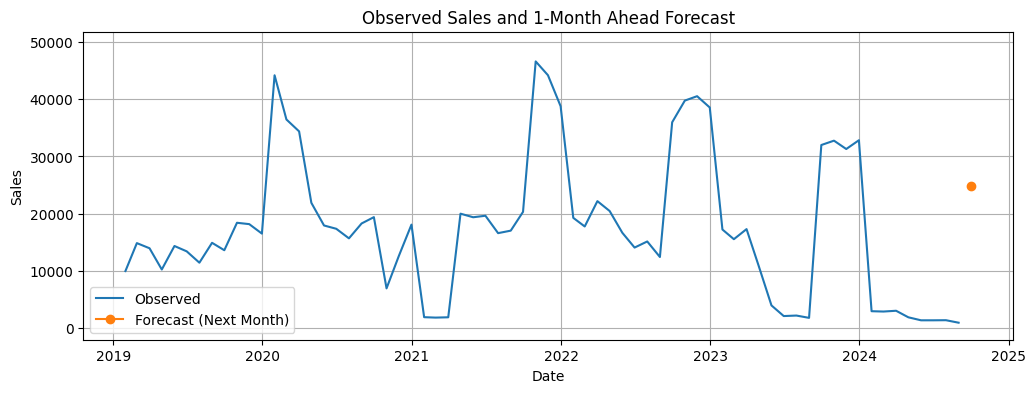

In [29]:
# Plot
plt.figure(figsize=(12,4))
plt.plot(monthly_sales, label='Observed')
plt.plot(forecast, marker='o', label='Forecast (Next Month)')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1], alpha=0.3)
plt.title('Observed Sales and 1-Month Ahead Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

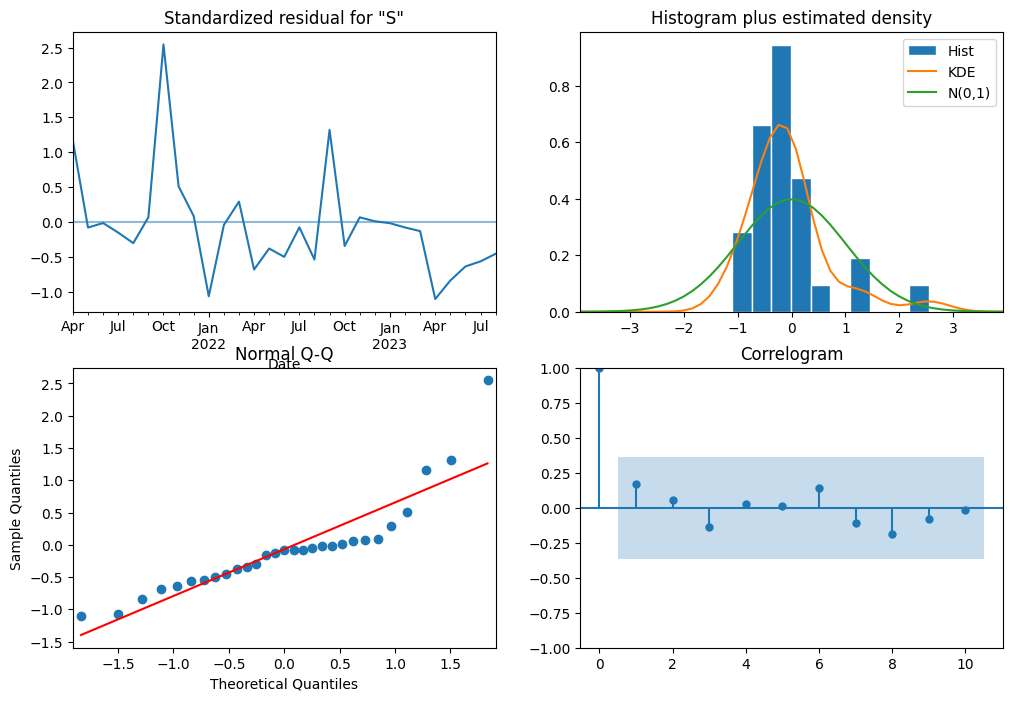

In [30]:
# ## 7. Model Diagnostics
results.plot_diagnostics(figsize=(12,8))
plt.show()
